## Propensity Score Matching
### 1. Concept

**PSM** constitutes a powerful technique in the context of observational studies. It aims to improve the study design by identifying the best comparable observational units (e.g., individuals, schools, companies etc.) to be included in the investigation. This capability is highly relevant because it permits observational studies to resemble one of the most important characteristics of purely experimental designs: **Random allocation of observational units to treatment conditions** (e.g., the levels of an independent variable). 

In a **RCT** study, often thought of as the gold standard approach to estimate treatment effects, the influence of potential confounders is reduced by random allocation of observational units to treatment conditions. This ensures that in each intervention group (e.g. therapy and control), relevant variables that might significantly explain variance in an outcome variable are balanced between the groups, thus minimizing their explanatory power across groups. In our example, we aim to compare individuals in terms of their facial emotion recognition performance. However, the literature suggests that fluid intelligence, biological sex and age are significantly related to this outcome variable. If one of the two groups were formed by individuals who are in general more intelligent, older, and mostly females, conclusions drawn in regard to the impact of an independent variable would not be **reliable** because observed differences in the dependent variable might have been caused by sex, intelligence or age (confounder effects). By randomly allocating participants to either group, we expect these variables to be balanced across the groups and therefore, not to have an effect on group differences on the outcome variable. Great! We have a chance to increase the **internal validity** of our experiment by minimizing the role of external variables (confounders). The problem is that in evaluation research, it is rarely possible to assign units to treatment groups by a random allocation. 

In fact, evaluation research normally deals with scenarios in which groups are already constituted, for instance when comparing classes within a school, individuals from different companies or when investigating **subject variables**. That is, if we want to compare participants with and without an autism disorder diagnostic, it would not make sense to randomly allocate participants in a control group and an intervention group, as the intervention group is by definition, formed by participants with autism disorder. **PSM** allows us to create different groups in which the effect of confounders is minimized by matching observational units accounting for covariates. In brief, **PSM** yields treatment groups that are equivalent in a set of relevant variables, in our example, biological sex, age and fluid intelligence. 

**Propensity scores** are **probabilities** of treatment assignment given covariate values at baseline. They are said to be balancing scores because conditional on them, the covariates' distributions are similar across groups. This means that in a set of individuals with similar propensity scores, the covariates' distributions are similar in the control and intervention groups.  

Let us see how it works. First, let us load our data again and perform some preprocessing:

In [2]:
#######################################################
## Specify R environment for rpy2
#import os
#os.environ['R_HOME'] = r'C:\Program Files\R\R-4.4.3'  # Replace with your R path
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects import Formula
import contextlib
# Ipython extension for plotting
%load_ext rpy2.ipython
########################################################

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import pingouin as pg


# Read the CSV file using a relative path
## Data frame
AU = pd.read_csv(f"../PSM/Datasets/AU.txt", sep="\t", escapechar='"', skipinitialspace=True)
KG = pd.read_csv(f"../PSM/Datasets/KG.txt", sep="\t", escapechar='"', skipinitialspace=True)


# Combine the AU and KG datasets
au_data = pd.concat([AU, KG], ignore_index=True)

# Select specific columns
au_data = au_data[["Gruppe", "Geschlecht", "Subject_id", "Alter", "Gminiq3"]]

# Remove rows with missing values
au_data = au_data.dropna()

# Rename the columns
au_data.columns = ["group", "b_sex", "Subject_id", "age", "f_inte"]

# Convert the 'group' column to numeric
au_data["group"] = pd.to_numeric(au_data["group"])

# Add an ID column
au_data['id'] = range(au_data.shape[0])

# Display the first few rows of the processed data
print(au_data.head())
au_data

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
   group  b_sex  Subject_id   age  f_inte  id
0      1      0       10001  12.0      28   0
1      1      0       10002   8.0      19   1
2      1      0       10003  13.0      27   2
3      1      1       11004  12.0      24   3
4      1      1       11005  14.0      41   4


,group,b_sex,Subject_id,age,f_inte,id
0,1,0,10001,12.0,28,0
1,1,0,10002,8.0,19,1
2,1,0,10003,13.0,27,2
3,1,1,11004,12.0,24,3
4,1,1,11005,14.0,41,4
...,...,...,...,...,...,...
162,0,1,21163,11.0,31,161
163,0,1,21164,18.0,35,162
164,0,1,21169,13.0,27,163
165,0,1,21170,14.0,25,164


### 2. Between-group differences

In our example, we are concerned that differences in intelligence might interfere with the effect of the novel therapy on facial emotion recognition. For illustrative purposes we will briefly investigate whether such significant differences exist:

Can you think of an easy way to test whether the two groups differ with respect to fluid intelligence? 
A simple ANOVA (or simply t-test when having only two groups) will answer this question. Use the next code chuck to run an ANOVA considering the kind of design that you have (e.g., within subjects?). Feel free to use any of the functions that you learned during the first tutorials.

In [3]:
# Perform one-way ANOVA
anova_results = pg.anova(dv='f_inte', between='group', data=au_data, detailed=True)

# Print the ANOVA results
print("One-Way ANOVA Results:")
print(anova_results)

# Perform t-test
t_test_results = pg.ttest(au_data[au_data["group"] == 0]["f_inte"], 
                          au_data[au_data["group"] == 1]["f_inte"], 
                          paired=False, 
                          correction=False)

# Print the t-test results
print("\nT-Test Results:")
print(t_test_results)

One-Way ANOVA Results:
   Source            SS   DF          MS         F     p-unc       np2
0   group    913.634763    1  913.634763  9.458538  0.002463  0.054529
1  Within  15841.359213  164   96.593654       NaN       NaN       NaN

T-Test Results:
               T  dof alternative     p-val          CI95%   cohen-d    BF10  \
T-test  3.075474  164   two-sided  0.002463  [2.24, 10.29]  0.637452  13.553   

           power  
T-test  0.863778  


### 3. Computation

In order to conduct PSM, we can use the `matchit()` function from the `MatchIt` package in R.

In [4]:
# Activate the pandas2ri conversion
pandas2ri.activate()

# Import the MatchIt package
matchit = importr('MatchIt')

# Put the data into the R environment
ro.globalenv['au_data'] = pandas2ri.py2rpy(au_data)

# Perform propensity score matching in R
ro.r('''
    library(MatchIt)
    m_out <- matchit(group ~ f_inte + b_sex + age, data = au_data, method = "nearest", distance = "glm", ratio = 1)
''')

# Summarize the matching results in R
m_out_summary = ro.r('summary(m_out)')

# Print the summary
print(m_out_summary)


Call:
matchit(formula = group ~ f_inte + b_sex + age, data = au_data, 
    method = "nearest", distance = "glm", ratio = 1)

Summary of Balance for All Data:
         Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance        0.2483        0.1525          0.7675     1.8190    0.2206
f_inte         26.7857       33.0507         -0.5483     1.4521    0.1496
b_sex           0.2857        0.4855         -0.4423          .    0.1998
age            12.9286       13.4493         -0.1868     2.1549    0.0679
         eCDF Max
distance   0.4120
f_inte     0.3949
b_sex      0.1998
age        0.1853

Summary of Balance for Matched Data:
         Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance        0.2483        0.2419          0.0518     1.1635    0.0076
f_inte         26.7857       26.8929         -0.0094     1.2805    0.0349
b_sex           0.2857        0.3214         -0.0791          .    0.0357
age            12.9286       13.0357         -0

### 4. Output interpretation

* First you will see the function that you called in the previous step.
* Then, you will see a table summarizing information from the two data sets. The first one includes all observations in our `au_data` data set. The second one provides the same estimates but this time only **matched observations** are included. This summary includes means of all confounders in both groups and. In addition, standardized mean differences (control group score - treatment group score) for each confounder are provided. Lastly, a variance ratio and differences in empirical cumulative density function (eCDF) are presented. 

In general, if the matching procedure worked well, we would expect to find smaller differences between the means and the eCDF of the two groups for all covariates. That is to say, values under the "Mean Diff" and the "eCDF" columns should be lower for the output corresponding to the matched data and ideally close to 0 (Summary of balance for matched data). 

* The "distance" row represents the measures that where considered to perform the matching. In this case, the propensity scores. 

* Finally, the last part of the output presents the sample sizes. Note that whereas all participants from the intervention group were used, only a same-sized subsample of the control group was included. Thus, 110 participants from the control group remain unmatched. This occurred because we used the argument "ratio=1" when calling the `matchit()` function, which means that each observation from the treatment group should be matched to only 1 observation from the control group. This explains why the values corresponding to the treatment group were the same under both "Summary of balance for all data:" and "Summary of balance for matched data:" sections in the output. The ratio value can be changed depending on the particular research scenario. 
  

Use the following code chunk to rerun the **PSM** but this time increase the ratio to 2 and have a look at the sample sizes provided by this output. Given that the ratio was changed to 2, 56 control participants were matched instead of 28.

In [5]:
# Perform propensity score matching in R
ro.r('''
    library(MatchIt)
    m_out <- matchit(group ~ f_inte + b_sex + age, data = au_data, method = "nearest", distance = "glm", ratio = 2)
''')

# Summarize the matching results in R
m_out_summary = ro.r('summary(m_out)')

# Print the summary
print(m_out_summary)


Call:
matchit(formula = group ~ f_inte + b_sex + age, data = au_data, 
    method = "nearest", distance = "glm", ratio = 2)

Summary of Balance for All Data:
         Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance        0.2483        0.1525          0.7675     1.8190    0.2206
f_inte         26.7857       33.0507         -0.5483     1.4521    0.1496
b_sex           0.2857        0.4855         -0.4423          .    0.1998
age            12.9286       13.4493         -0.1868     2.1549    0.0679
         eCDF Max
distance   0.4120
f_inte     0.3949
b_sex      0.1998
age        0.1853

Summary of Balance for Matched Data:
         Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance        0.2483        0.2189          0.2360     1.5485    0.0403
f_inte         26.7857       28.5357         -0.1532     1.6878    0.0683
b_sex           0.2857        0.3036         -0.0395          .    0.0179
age            12.9286       13.1964         -0

  
### 5. Graphical output
  
In addition to the table-form output, it is possible to graphically inspect the PSM results: 
  
#### A. Distribution of Propensity Scores

The code line below displays the **Propensity Score Distributions** of matched and unmatched control and intervention groups. The first cell, under "Unmatched Treatment Units" is empty because all intervention observations were used for matching. This is not the case for the control group. Note that each dot under "Matched Treatment Units" has a corresponding dot under "Unmatched Treatment Units" (they are "in line"). This is an indication of how the matching procedure worked, meaning that the observations were matched considering their propensity scores. Finally, remember that propensity scores are probability values, so the maximal possible value is 1.

The line below displays the **Propensity Score Distributions** of matched and unmatched control and intervention groups. The first cell, under "Unmatched Treatment Units" is empty because all intervention observations were used for matching. This is not the case for the control group. Note that each dot under "Matched Treatment Units" has a corresponding dot under "Unmatched Treatment Units" (they are "in line"). This is an indication of how the matching procedure worked, meaning that the observations were matched considering their propensity scores. Finally, remember that propensity scores are probability values, so the maximal possible value is 1.

To identify the units, use first mouse button; to stop, use second.


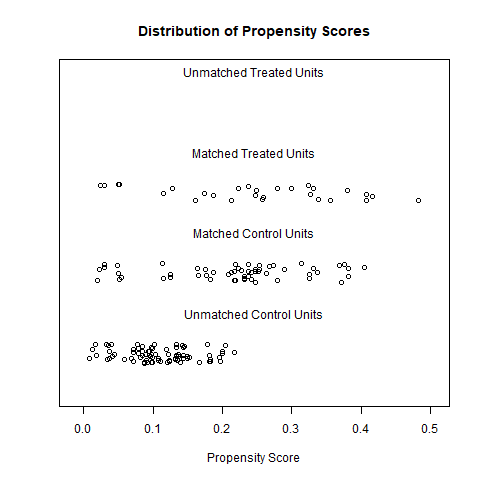

In [6]:
%%R
plot(m_out, type = "jitter")

#### B. Distribution of Propensity Histograms

The `plot` below returns four histograms corresponding to intervention and control groups before and after **PSM**. In general, if the PSM properly worked, we would expect the upper and lower right figures to be more similar than the  upper and lower left figures. In other words, the propensity score distributions should be more similar between the intervention and control groups after PSM.


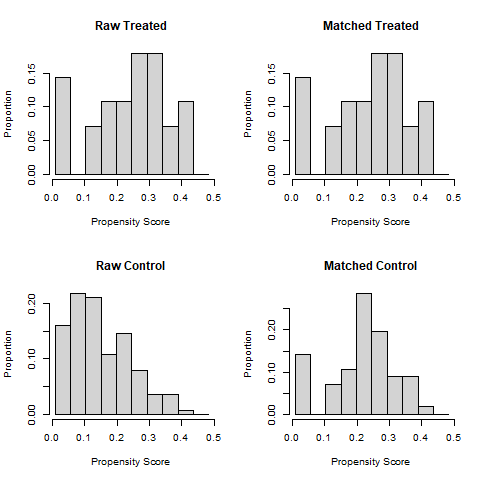

In [7]:
%%R
plot(m_out, type = "hist")

### 6. Output data

We can now extract the data set containing only the observations that have been matched to conduct further analysis: 

We now use the `match.data()` function to extract the data frame that resulted from PSM with ratio = 1. We call the data frame "matched_au". Then inspect the data frame and repeat the ANOVA analysis on fluid intelligence to check whether significant between-group differences remain. 



In [8]:
# Perform match data in R
ro.r('matched_au <- match.data(m_out)')

# Convert the R DataFrame to a pandas DataFrame
matched_au = pandas2ri.rpy2py(ro.r('matched_au'))

# Perform one-way ANOVA using the matched data in Python
anova_results = pg.anova(dv='f_inte', between='group', data=matched_au, detailed=True)

# Print the ANOVA results
print("One-Way ANOVA Results:")
print(anova_results)

One-Way ANOVA Results:
   Source           SS  DF         MS         F     p-unc       np2
0   group    57.166667   1  57.166667  0.602633  0.439809  0.007296
1  Within  7778.642857  82  94.861498       NaN       NaN       NaN


These results demonstrate that after performing PSM the two groups do not significantly differ in fluid intelligence. As such, observed differences in face processing skills are less likely to be explained by it. 